In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt





%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 10)
pd.set_option('display.max_rows', 500)

import plotly.graph_objects as go

In [3]:
from prophet import Prophet

In [4]:
%matplotlib inline
plt.style.use('fivethirtyeight')

In [5]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Generating Trivial Forecast Data

In [6]:
df = pd.DataFrame({'X': np.arange(0,10)}) # generate an input df
df['y']=df.rolling(3).mean() # take the window and write the average as the result

# Small Dataset

In [7]:
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';')
df=df_all[['date','Germany']]
df=df.rename(columns={'date': 'ds',
                        'Germany': 'y'})

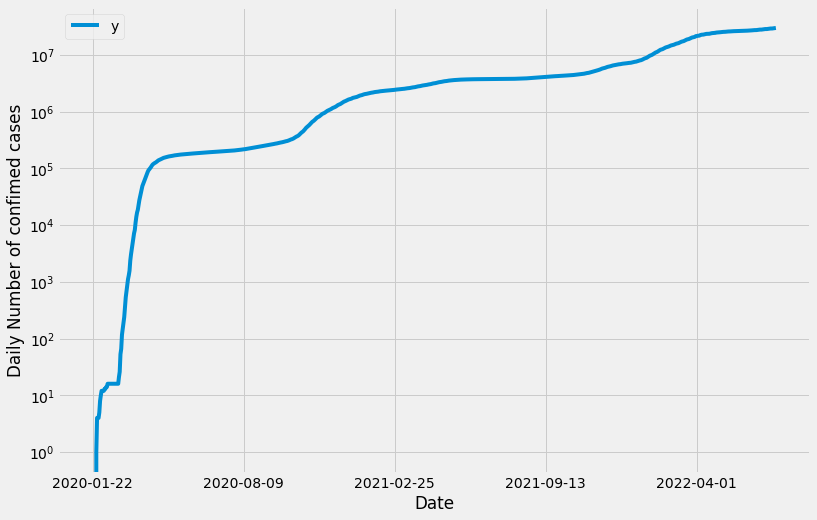

In [8]:
ax = df.set_index('ds').plot(figsize=(12, 8),
                             logy=True)
ax.set_ylabel('Daily Number of confimed cases')
ax.set_xlabel('Date')

plt.show()


In [9]:
my_model = Prophet(growth='logistic') 

In [10]:
df['cap']=1000000.
my_model.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -51.7196


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       651.909   9.71494e-08       101.388   9.635e-10       0.001      153  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       651.909   7.18251e-09       100.898      0.3089      0.3089      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [11]:

future_dates = my_model.make_future_dataframe(periods=7, freq='D')
future_dates['cap']=1000000. # only mandatory for the logistic model
future_dates.tail()

,ds,cap
908,2022-07-18,1000000.0
909,2022-07-19,1000000.0
910,2022-07-20,1000000.0
911,2022-07-21,1000000.0
912,2022-07-22,1000000.0


In [12]:
forecast = my_model.predict(future_dates)

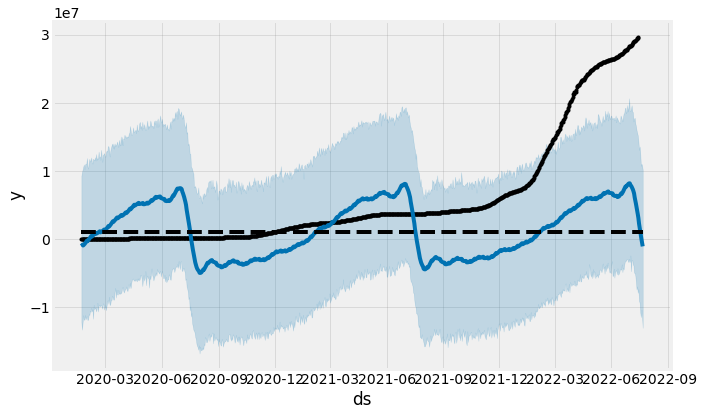

In [13]:
my_model.plot(forecast,
              uncertainty=True ); # since fbprohet is rendering the output

In [14]:
import plotly.offline as py
from prophet.plot import plot_plotly

fig = plot_plotly(my_model, forecast)  # This returns a plotly Figure

fig.update_layout(
    width=1024,
    height=900,
    xaxis_title="Time",
    yaxis_title="Confirmed infected people (source johns hopkins csse, log-scale)",
)
fig.update_yaxes(type="log")#,range=[1.1,5.5])
py.iplot(fig)

In [15]:
forecast.sort_values(by='ds').head()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,111436.699891,1000000.0,-1.217583e+07,9.288072e+06,111436.699891,111436.699891,-1.110820e+06,-1.110820e+06,-1.110820e+06,29809.408129,29809.408129,29809.408129,-1.140629e+06,-1.140629e+06,-1.140629e+06,0.0,0.0,0.0,-999383.248122
1,2020-01-23,112446.290456,1000000.0,-1.326674e+07,9.883899e+06,112446.290456,112446.290456,-1.010940e+06,-1.010940e+06,-1.010940e+06,71375.835819,71375.835819,71375.835819,-1.082316e+06,-1.082316e+06,-1.082316e+06,0.0,0.0,0.0,-898493.482996
2,2020-01-24,113463.859707,1000000.0,-1.218062e+07,1.019777e+07,113463.859707,113463.859707,-9.110332e+05,-9.110332e+05,-9.110332e+05,107416.987006,107416.987006,107416.987006,-1.018450e+06,-1.018450e+06,-1.018450e+06,0.0,0.0,0.0,-797569.372743
3,2020-01-25,114489.449501,1000000.0,-1.115266e+07,1.062216e+07,114489.449501,114489.449501,-1.025866e+06,-1.025866e+06,-1.025866e+06,-76900.549437,-76900.549437,-76900.549437,-9.489659e+05,-9.489659e+05,-9.489659e+05,0.0,0.0,0.0,-911377.048940
4,2020-01-26,115523.101524,1000000.0,-1.180279e+07,1.097419e+07,115523.101524,115523.101524,-9.384608e+05,-9.384608e+05,-9.384608e+05,-64504.089107,-64504.089107,-64504.089107,-8.739567e+05,-8.739567e+05,-8.739567e+05,0.0,0.0,0.0,-822937.715508


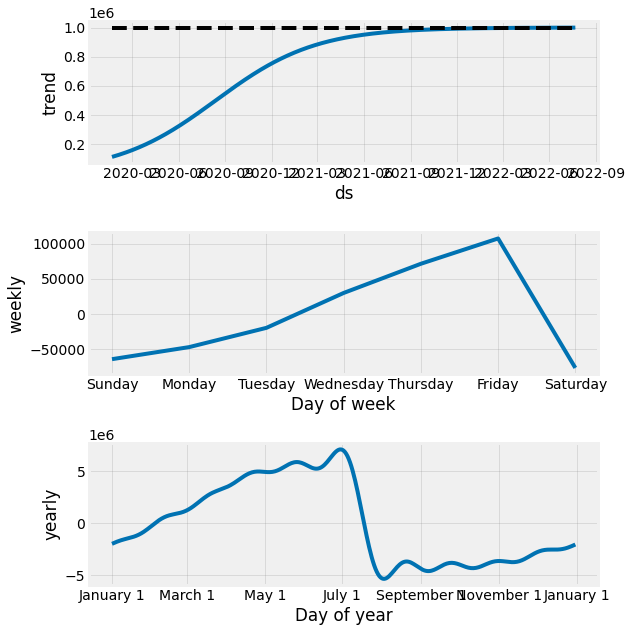

In [16]:
my_model.plot_components(forecast);

<AxesSubplot:xlabel='ds'>

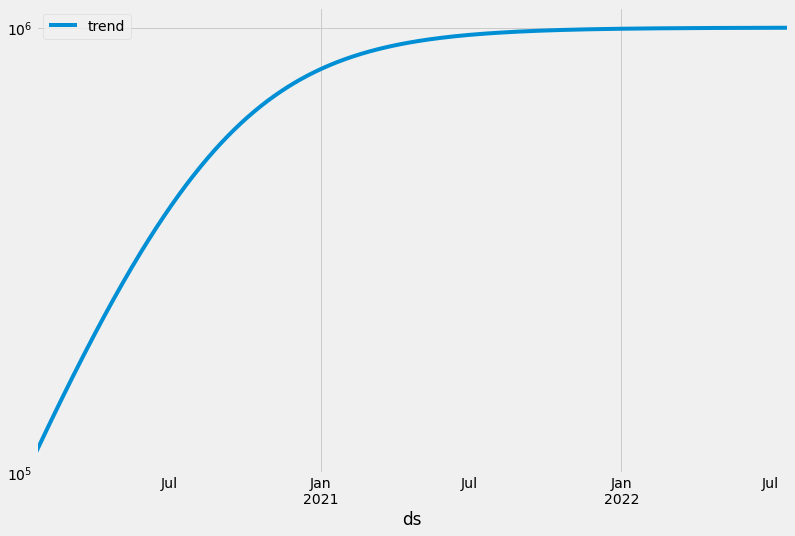

In [17]:
forecast[['ds','trend']].set_index('ds').plot(figsize=(12, 8),logy=True)

# Cross Validation

In [51]:
from prophet.diagnostics import cross_validation
df_cv = cross_validation(my_model, 
                         initial='200 days', # we take the first 30 days for training
                         period='25 days',  # every  days a new prediction run
                         horizon = '75 days') #we predict 7days into the future

INFO:prophet:Making 26 forecasts with cutoffs between 2020-08-14 00:00:00 and 2022-05-01 00:00:00


  0%|          | 0/26 [00:00<?, ?it/s]

Initial log joint probability = -12.0161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1048.52     0.0188189       996.358           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1070.04    0.00454443       2218.09      0.4228           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1080.99   0.000911433       1080.81       0.717       0.717      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1087.37   0.000216983       1158.99      0.2089      0.2089      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       1090.04   4.07467e-05       160.109      0.2167      0.2167      567   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [52]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-15,223745.727994,222858.911308,224597.916391,222828,2020-08-14
1,2020-08-16,225781.376800,224882.571447,226673.245364,223453,2020-08-14
2,2020-08-17,228150.389366,227286.986935,228974.352211,224014,2020-08-14
3,2020-08-18,231096.217564,230262.300134,231948.642998,225404,2020-08-14
4,2020-08-19,234593.539025,233728.332281,235469.970904,226914,2020-08-14


In [53]:
df_cv.sort_values(by = ['cutoff', 'ds'])[0:14]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-08-15,223745.727994,222858.911308,224597.916391,222828,2020-08-14
1,2020-08-16,225781.376800,224882.571447,226673.245364,223453,2020-08-14
2,2020-08-17,228150.389366,227286.986935,228974.352211,224014,2020-08-14
3,2020-08-18,231096.217564,230262.300134,231948.642998,225404,2020-08-14
4,2020-08-19,234593.539025,233728.332281,235469.970904,226914,2020-08-14
5,2020-08-20,238992.447973,238131.500004,239813.741732,228621,2020-08-14
6,2020-08-21,244088.449155,243298.983774,244936.353728,230048,2020-08-14
7,2020-08-22,249831.771731,249020.551850,250748.286673,232082,2020-08-14
8,2020-08-23,255959.187469,255044.854319,256848.864699,232864,2020-08-14
9,2020-08-24,262806.352799,261901.609750,263704.458921,233575,2020-08-14


In [54]:
df[['ds', 'y']][30:]

,ds,y
30,2020-02-21,16
31,2020-02-22,16
32,2020-02-23,16
33,2020-02-24,16
34,2020-02-25,16
...,...,...
901,2022-07-11,29180489
902,2022-07-12,29308100
903,2022-07-13,29460249
904,2022-07-14,29569943


/home/dell/anaconda3/envs/env/lib/python3.7/site-packages/prophet/plot.py:539: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

/home/dell/anaconda3/envs/env/lib/python3.7/site-packages/prophet/plot.py:540: FutureWarning:

casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.



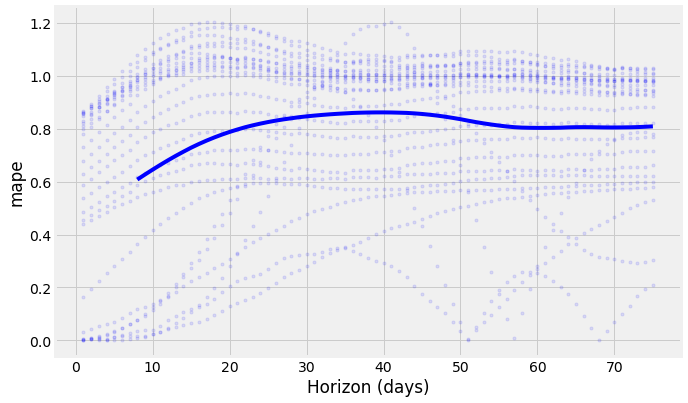

In [55]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape',)

# Diagonal Plot

In [56]:
horizon='75 days'
df_cv['horizon']=df_cv.ds-df_cv.cutoff

date_vec=df_cv[df_cv['horizon']==horizon]['ds']
y_hat=df_cv[df_cv['horizon']==horizon]['yhat']
y=df_cv[df_cv['horizon']==horizon]['y']

In [57]:
df_cv_7=df_cv[df_cv['horizon']==horizon]
df_cv_7.tail()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,horizon
1649,2022-04-06,436412.124476,-2.582786e+06,3.097518e+06,22265788,2022-01-21,75 days
1724,2022-05-01,489463.125592,-2.874622e+06,4.255466e+06,24813817,2022-02-15,75 days
1799,2022-05-26,252312.229490,-4.092373e+06,4.822285e+06,26200663,2022-03-12,75 days
1874,2022-06-20,-189009.161067,-6.209555e+06,5.987854e+06,27334993,2022-04-06,75 days
1949,2022-07-15,-756424.785854,-8.497938e+06,6.353317e+06,29692989,2022-05-01,75 days


In [58]:
type(df_cv['horizon'][0])

pandas._libs.tslibs.timedeltas.Timedelta

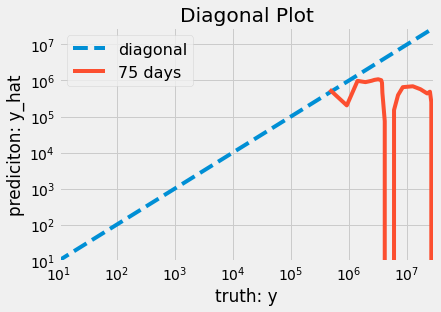

In [59]:
fig, ax = plt.subplots(1, 1)


ax.plot(np.arange(max(y)),np.arange(max(y)),'--',label='diagonal')
ax.plot(y,y_hat,'-',label=horizon)  # horizon is a np.timedelta objct

ax.set_title('Diagonal Plot')
ax.set_ylim(10, max(y))

ax.set_xlabel('truth: y')
ax.set_ylabel('prediciton: y_hat')
ax.set_yscale('log')

ax.set_xlim(10, max(y))
ax.set_xscale('log')
ax.legend(loc='best',
           prop={'size': 16});

# Trivial Forcasting

In [60]:
def mean_absolute_percentage_error(y_true, y_pred): 
    ''' MAPE calculation '''
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [61]:
parse_dates=['date']
df_all = pd.read_csv('../data/processed/COVID_small_flat_table.csv',sep=';',parse_dates=parse_dates)
df_trivial=df_all[['date','Germany']]
df_trivial=df_trivial.rename(columns={'date': 'ds',
                        'Germany': 'y'})

## One of standard forecast is a rolling mean

In [62]:
df_trivial['y_mean_r3']=df_trivial.y.rolling(3).mean() # take the average of 3 days

In [63]:

df_trivial['cutoff']=df_trivial['ds'].shift(7)
df_trivial['y_hat']=df_trivial['y_mean_r3'].shift(7)
df_trivial['horizon']=df_trivial['ds']-df_trivial['cutoff']
print('MAPE: '+str(mean_absolute_percentage_error(df_trivial['y_hat'].iloc[12:,], df_trivial['y'].iloc[12:,])))
df_trivial

MAPE: 35.77591601014491


,ds,y,y_mean_r3,cutoff,y_hat,horizon
0,2020-01-22,0,NaN,NaT,NaN,NaT
1,2020-01-23,0,NaN,NaT,NaN,NaT
2,2020-01-24,0,0.000000e+00,NaT,NaN,NaT
3,2020-01-25,0,0.000000e+00,NaT,NaN,NaT
4,2020-01-26,0,0.000000e+00,NaT,NaN,NaT
...,...,...,...,...,...,...
901,2022-07-11,29180489,2.907617e+07,2022-07-04,2.844337e+07,7 days
902,2022-07-12,29308100,2.917145e+07,2022-07-05,2.853690e+07,7 days
903,2022-07-13,29460249,2.931628e+07,2022-07-06,2.867477e+07,7 days
904,2022-07-14,29569943,2.944610e+07,2022-07-07,2.880272e+07,7 days
